In [57]:
#import module for multimodal model for air pollution
from models.multimodal_model import PMModel
# import the module to create the multiModal dataset
from models.data_loader import AirPollutionDataset
from torch.utils.data import DataLoader
import torch
# ramdomsplit is used to divide the dataset as train test split
from torch.utils.data import random_split
from torch import nn
from torch import optim 
from torchvision import  transforms
from torch import random
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt


In [58]:
if torch.cuda.is_available(): 
 device = "cuda" 
else: 
 device = "cpu"
device

'cpu'

In [59]:
import numpy as np
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  # For CUDA (GPU) reproducibility
torch.backends.cudnn.benchmark = False    # Disabling this may improve reproducibility

In [60]:
#transforms
transform =transforms.Compose([
        #transforms.CenterCrop(10),
        transforms.Resize((224,224)),
        transforms.PILToTensor()

        #transforms.ConvertImageDtype(torch.float)
        ]
)


In [61]:
# create the mulyimodal dataset
images_dir='data_dir'
csv_file='multimodal_dataset.csv'


#transform = transforms.Resize(output_size)
dataset = AirPollutionDataset(images_dir,csv_file,transform=transform)


In [62]:
class LinearRegressionModel(nn.Module):
 
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(5, 1)  # One in and one out
 
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [63]:
# creation of the dataloader
# Define the proportions for train, validation, and test sets
train_ratio = 0.8# 80% for training
val_ratio = 0.1# 10% for validation
test_ratio = 0.1 # 10% for testing

# Calculate the lengths of each split
total_samples = len(dataset)
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

# Use random_split to create the splits
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader instances for each split
batch_size = 4
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

56
7
8


In [64]:
# Instantiate your model
model =LinearRegressionModel()

# Define loss function and optimizer
l2_lambda = 0.1
criterion = nn.MSELoss()  # For example, you can change this based on your task
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [65]:
# Training loop
num_epochs =100

val_losses=[]
train_losses=[]
for epoch in range(num_epochs):
    model.train()
    avg_trainloss=0.0
    total_train_loss=0.0
    for batch_data in train_loader:
       # print(len(batch_data))
        S5no2,S5so2,tabular,labels=batch_data
        S5no2=S5no2.float().to(device)
        S5so2=S5so2.float().to(device)
        tabular=tabular.float().to(device)
        labels=labels.float().reshape(-1,1).to(device)
        #print(S5no2.shape)
        #print(tabular)
        
        
        optimizer.zero_grad()
      
        outputs = model(tabular).float()
        #l2_loss = sum(p.norm(2) for p in model.parameters())
        loss = criterion(outputs, labels)
        #loss = loss + l2_lambda * l2_loss
        total_train_loss+=loss
        
        #loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    avg_trainloss=total_train_loss/len(train_loader)
       
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_r=0.0
        for batch_data in val_loader:
            #print(len(batch_data))
            S5no2,S5so2,tabular,labels=batch_data 
            S5no2=S5no2.float().to(device)
            S5so2=S5so2.float().to(device)
            tabular=tabular.float().to(device)
            labels=labels.float().reshape(-1,1).to(device)
            outputs = model(tabular)
            val_loss += criterion(outputs, labels)
            val_r+= r2_score(outputs.cpu(),labels.cpu())
            
        average_val_loss = val_loss / len(val_loader)
        average_val_r=val_r/len(val_loader)
        
        val_losses.append(average_val_loss.item())
        train_losses.append(avg_trainloss.item())
        torch.save(model.state_dict(), f'models/checkpoints/cnn_backbone/model_epoch_{epoch+1}.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train loss : {avg_trainloss}  - Val Loss: {average_val_loss.item()}  - Rsquare:{average_val_r}")


Epoch [1/100] - Train loss : 2597.267333984375  - Val Loss: 1411.099853515625  - Rsquare:-127.51217613660629
Epoch [2/100] - Train loss : 2171.06884765625  - Val Loss: 1375.1407470703125  - Rsquare:-127.2169865331171
Epoch [3/100] - Train loss : 2160.43017578125  - Val Loss: 1340.8211669921875  - Rsquare:-126.9179828822334
Epoch [4/100] - Train loss : 2097.531494140625  - Val Loss: 1306.072998046875  - Rsquare:-126.62309155568167
Epoch [5/100] - Train loss : 2055.99951171875  - Val Loss: 1272.6038818359375  - Rsquare:-126.33162485772498
Epoch [6/100] - Train loss : 2025.2705078125  - Val Loss: 1238.9708251953125  - Rsquare:-126.04438939670145
Epoch [7/100] - Train loss : 1991.4156494140625  - Val Loss: 1206.4334716796875  - Rsquare:-125.7472309682173
Epoch [8/100] - Train loss : 1943.912841796875  - Val Loss: 1173.3948974609375  - Rsquare:-125.4611610110063
Epoch [9/100] - Train loss : 1904.3067626953125  - Val Loss: 1141.9395751953125  - Rsquare:-125.17226843252797
Epoch [10/100] - Tr

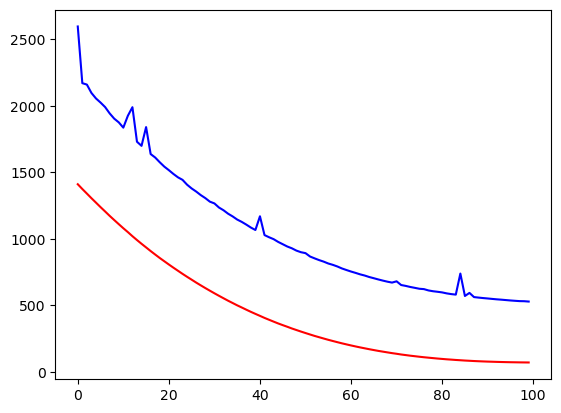

In [66]:
#plt.plot(val_losses)
import numpy as np
#print(val_losses)
plt.plot(np.arange(len(train_losses)),train_losses,'b')
plt.plot(np.arange(len(train_losses)),val_losses,'r')
plt.show()

In [67]:
torch.save(model.state_dict(), f'models/checkpoints/regression/model_regression.pth')

In [69]:
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error,median_absolute_error
model.eval()

# Make predictions on the test set
y_true = []
y_pred = []

with torch.no_grad():
    for batch_data in test_loader:
        S5no2,S5so2,tabular,labels=batch_data 
        S5no2=S5no2.float().to(device)
        S5so2=S5so2.float().to(device)
        tabular=tabular.float().to(device)
        labels=labels.float().reshape(-1,1).to(device)
        outputs = model(tabular)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.numpy())

# Calculate R-squared score
r2 = r2_score(y_true, y_pred)
mse=mean_squared_error(y_true,y_pred)
mae=mean_absolute_error(y_true,y_pred)
rmse=mean_squared_error(y_true,y_pred)**0.5

print(f"R-squared score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R-squared score: -0.0841
MSE: 148.5221
RMSE: 12.1870
MAE: 5.6075
